# ライブラリのインポート

In [1]:
# ライブラリ読み込み

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image, display
import segmentation_models_pytorch as smp
import torch

# モデルの読み込み

In [2]:
# モデルを宣言
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['normal']
ACTIVATION = 'sigmoid'  # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cpu'
DECODER = 'unet'
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)
model = model.to("cpu")

naiku_model_path = './best_model_Unet_with_lumina_efficientnet-b7_4001.pth'
not_naiku_model_path = "./best_model_Unet_without_lumina_efficientnet-b7_4001.pth"
naiku_model = torch.load(naiku_model_path, map_location='cpu')
not_naiku_model = torch.load(not_naiku_model_path, map_location='cpu')

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# 画像データの確認

In [4]:
im = cv2.imread('./IR30/seq0.png')

print(type(im))
# <class 'numpy.ndarray'>

print(im.shape)
# (225, 400, 3)

print(im.dtype)
# uint8


<class 'numpy.ndarray'>
(256, 256, 3)
uint8


# 尿細管壁の高さを出力する関数

In [5]:
def FromModelMeasureHight(seq, sure_fig_p):
    
    '''
    尿細管壁の高さを自動計算する関数
    
    parameters
    ----------------
    seq : int
        画像のシークエンス番号
    sure_fig_p : float
        尿細管個数の調整
        
    returns(print)
    ----------------
    尿細管の個数 : int
    尿細管の高さの平均値 : float
    元画像 : image
    セグメンテーション画像（2種）: image
    尿細管分離画像 : image
    
        
    '''
    image_src = cv2.imread('./IR30/seq{}.png'.format(seq))
    image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)

    # 前処理
    image = preprocessing_fn(image_src)
    image = image.transpose(2, 0, 1).astype('float32')

    # モデルで推論
    image = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    predict = naiku_model(image)
    predict = predict.detach().cpu().numpy()[0].reshape((256,256))
#     plt.imshow(predict)

    # 0.5以上を1とする
    predict_img = np.zeros([256,256]).astype(np.int8)
    # predict_img = np.where(predict&gt;0 .5, 1 , predict_img)
    predict_img = np.where(predict>0.5, 1 , predict_img) 

    #形状の変換
    predict_img = np.where(predict_img == 1, 0, 255)
    imgray = predict_img.astype('uint8')
    im_naiku = np.stack([imgray, imgray, imgray], 2)
    
    
    image_src_not = cv2.imread('./IR30/seq{}.png'.format(seq))
    image_src_not = cv2.cvtColor(image_src_not, cv2.COLOR_BGR2RGB)

    # 前処理
    image_not = preprocessing_fn(image_src_not)
    image_not = image_not.transpose(2, 0, 1).astype('float32')

    # モデルで推論
    image_not = torch.from_numpy(image_not).to(DEVICE).unsqueeze(0)
    predict_not = not_naiku_model(image_not)
    predict_not = predict_not.detach().cpu().numpy()[0].reshape((256,256))
#     plt.imshow(predict_not)

    # 0.5以上を1とする
    predict_img_not = np.zeros([256,256]).astype(np.int8)
    # predict_img = np.where(predict&gt;0 .5, 1 , predict_img)
    predict_img_not = np.where(predict_not>0.5, 1 , predict_img_not)  
    
    # # 横並び
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    ax1.imshow(predict)
    ax2.imshow(predict_not)
    ax3.imshow(image_src)
    ax4.imshow(predict_img_not)  
    
    #形状の変換
    predict_img_not = np.where(predict_img_not == 1, 0, 255)
    imgray_not = predict_img_not.astype('uint8')
    im_hole = np.stack([imgray_not, imgray_not, imgray_not], 2)
    
    #内腔抜きの画像を読み込む
    im_naiku_gray = cv2.cvtColor(im_naiku,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(im_naiku_gray, 0, 255, cv2.THRESH_BINARY)

    tubele = np.count_nonzero(thresh == 255)#尿細管壁の合計面積#26024
    
    #内腔も白くなっている画像を読み込む
    imgray_hole = cv2.cvtColor(im_hole,cv2.COLOR_BGR2GRAY)
    ret,thresh_hole = cv2.threshold(imgray_hole, 127, 255, cv2.THRESH_BINARY)
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh_hole)
    
    back = stats[0][4]#背景全体の合計面積
    hole = 256*256#画像全体の面積hole
    
    naiku_hole = hole - back - tubele#内腔の合計面積
    tubule_hole = hole - back#内腔も含めた尿細管の面積
    
    
    #watershedにより組織画像内の近位尿細管個数を算出する
    #ノイズ除去
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))#ノイズ除去用カーネル
    bin_img = cv2.morphologyEx(thresh_hole, cv2.MORPH_OPEN, kernel1, iterations=2)#オープニング、収縮のあとに膨張してノイズを除去

    #sure background
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))#sure background用カーネル
    sure_bg = cv2.dilate(bin_img, kernel2, iterations=3)#膨張処理

    #sure foreground
    dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist, sure_fig_p* dist.max(), 255, cv2.THRESH_BINARY)
    sure_fg = sure_fg.astype(np.uint8)  # float32 -> uint8

    #判別できない部分
    unknown = cv2.subtract(sure_bg, sure_fg)

    #それぞれの尿細管にlabel付け
    ret, markers = cv2.connectedComponents(sure_fg)
    # 前景か背景か判断できない領域はラベル0
    markers += 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(im_hole, markers)

    labels = np.unique(markers)

    #watershed アルゴリズムの結果を元に輪郭抽出を行う
    coins = []
    for label in labels[2:]:  # 0:背景ラベル １：境界ラベル は無視する。

        # ラベル label の領域のみ前景、それ以外は背景となる2値画像を作成する。
        target = np.where(markers == label, 255, 0).astype(np.uint8)

        # 作成した2値画像に対して、輪郭抽出を行う。
        contours, hierarchy = cv2.findContours(
            target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        coins.append(contours[0])

    # 輪郭を描画する。
    cv2.drawContours(im_hole, coins, -1, color=(0, 0, 255), thickness=2)
    plt.imshow(im_hole)
    plt.show
    
    #半径の計算
    R = np.sqrt(((tubule_hole)/len(coins)) / np.pi)#尿細管自体の半径
    r = np.sqrt((naiku_hole/len(coins)) / np.pi)#尿細管の内腔の半径

    print("watershedによる近位尿細管個数：{}".format(len(coins)))
    print("尿細管壁の高さの平均：{:.4f}".format(R-r))


    
    
    
    
    


watershedによる近位尿細管個数：54
尿細管壁の高さの平均：7.4741


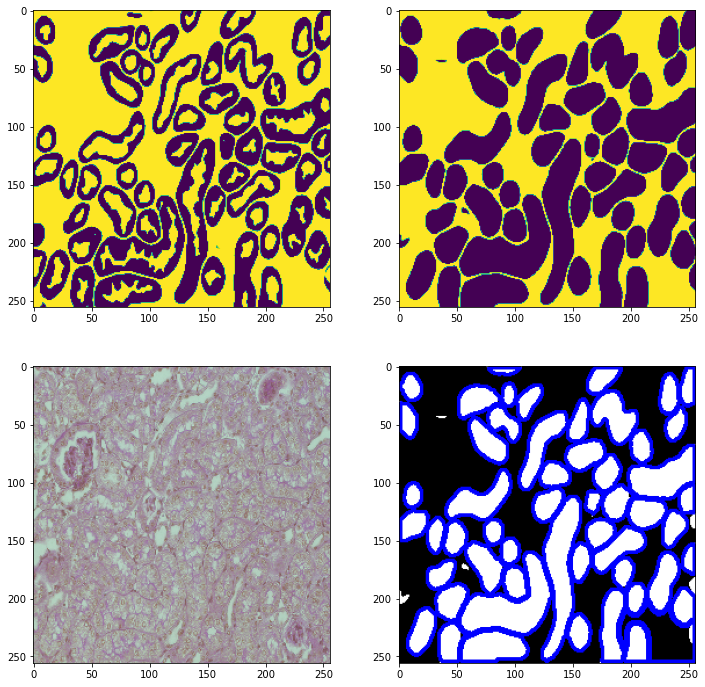

In [6]:
FromModelMeasureHight(seq=0, sure_fig_p=0.3)